In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# log
def log(msg):
    now = datetime.strftime(datetime.now(tz=pytz.timezone('Hongkong')), '%Y-%m-%d %H:%M:%S')
    print(f'[{now}] {msg}')
    
# pickle
def save_pkl(obj, filename):
    pickle.dump(obj, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    return
def load_pkl(filename):
    return pickle.load(open(filename, 'rb'))

def get_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def dl_txt(full_path):
    copyfile(full_path, full_path.split('/')[-1])
    print(f"Copied {full_path.split('/')[-1]}")
    return

def clear_output():
    for file in os.listdir():
        os.remove(file)
    return

fig_num = 0
def new_plot():
    global fig_num
    fig_num += 1
    plt.figure(fig_num)
    
import signal as signal_
class TimeoutException(Exception):   # Custom exception class
    pass
def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException
signal_.signal(signal_.SIGALRM, timeout_handler)

<Handlers.SIG_DFL: 0>

In [3]:
# params
bt_start_date = '2014-01-01' # bt - back testing
bt_end_date = '2018-03-27'
seed = 0
horizons = {'1m':21*1,'2m':21*2,'3m':21*3,'6m':21*6, '9m':21*9, '12m':21*12}
h = '12m'
n_day_horizon = int(horizons[h] * 365/252)
device_type = 'GPU'
run_hp_tune = True
n_day_sample = 4
hp_opt_hrs = 2
n_day_trn, n_day_val = 365, 30
n_day_final_predict = 10000
# early_stopping_rounds = 100

In [4]:
# load excess return
def load_exret(n_day):
    exret = pd.read_csv('../input/hkml-download-returns/exret.csv').assign(date = lambda x: pd.to_datetime(x.date)).set_index('date')
    exret = (1+exret).rolling(n_day).apply(np.prod, raw=True).shift(-n_day) - 1
    exret = exret \
        .unstack() \
        .loc[lambda x: x.notnull()] \
        .reset_index() \
        .rename(columns={'level_0':'stock',0:'exret'})
    log(f'Shape of exret: {exret.shape}')
    return exret


# load 10-K signals
def load_signals():
    feats_10k = pd.merge(pd.read_csv('../input/hkml-signal-extraction-10k-cpu/feats.csv'),
                     pd.read_csv('../input/hkml-signal-extraction-gpu/feats.csv'),
                     how='inner', on=['doc_id','cik','entity','filing_date','stock']) \
        .rename(columns={'filing_date':'date'}) \
        .assign(date = lambda x: pd.to_datetime(x.date),
                cik = lambda x: x.cik.astype(str).str.zfill(10)) \
        .replace([np.inf, -np.inf], np.nan)
    feat_names = [c for c in feats_10k.columns if 'feat' in c]
    feats_10k = feats_10k.rename(columns={c:c+'_10k' for c in feat_names})
    feats_10k = feats_10k.loc[:,['stock','date'] + [c for c in feats_10k.columns if 'feat' in c]]
    log(f'Shape of 10-K feats: {feats_10k.shape}')

    # load 10-Q signals
    feats_10q = pd.read_csv('../input/hkml-signal-extraction-10q-cpu/feats.csv') \
        .rename(columns={'filing_date':'date'}) \
        .assign(date = lambda x: pd.to_datetime(x.date),
                cik = lambda x: x.cik.astype(str).str.zfill(10)) \
        .replace([np.inf, -np.inf])
    feat_names = [c for c in feats_10q.columns if 'feat' in c]
    feats_10q = feats_10q.rename(columns={c:c+'_10q' for c in feat_names})
    feats_10q = feats_10q.loc[:,['stock','date'] + [c for c in feats_10q.columns if 'feat' in c]]
    log(f'Shape of 10-Q feats: {feats_10q.shape}')

    # load 8-k signal
    feats_8k = load_pkl('../input/hkml-signal-extraction-pre/feats_8k')
    log(f'Shape of 8-K feats: {feats_8k.shape}')

    # combine all signals into single df
    feats = feats_10k \
        .merge(feats_10q, how='outer', on=['stock','date']) \
        .merge(feats_8k, how='outer', on=['stock','date']) \
        .sort_values(['stock','date']) \
        .groupby('stock') \
        .apply(lambda x: x.ffill()) \
        .reset_index(drop=True)
    feat_names = [c for c in feats.columns if 'feat' in c]
    log(f'Shape of combined feats: {feats.shape}')

    # remove all nulls rows
    feats = feats.loc[lambda x: x[feat_names].notnull().sum(axis=1) > 0]
    return feats, feat_names


# merge signal and rank to build the complete dataset
def preprocess_signals(feats, exret):
    # merge with rank data    
    data = feats \
        .merge(exret, how='outer', on=['stock','date']) \
        .sort_values(['stock','date'])
    # fillna signal
    data[feat_names] = data.groupby('stock')[feat_names].ffill()
    data = data.loc[lambda x: x[feat_names].notnull().sum(axis=1) > 0]
    data[feat_names] = data[feat_names].fillna(data[feat_names].mean(axis=0))
    # derive rank of exret
    data = data.sort_values(['date','exret']).reset_index(drop=True)
    data['rank'] = data.groupby('date')['exret'].rank()
    data = data \
        .loc[lambda x: x['rank'].notnull()] \
        .sort_values(['date','rank']) \
        .drop('exret', axis=1) \
        .reset_index(drop=True)
    log(f'Shape of full dataset: {data.shape}')
    log(f'Number of nulls in full dataset: {data.isnull().sum().sum()}')
    
    # check group size distribution
    new_plot()
    data.groupby('date').size().hist(bins=50)
    plt.title('Group size distribution')

    # scaling
    data[feat_names] = StandardScaler().fit_transform(data[feat_names])
    
    # fianl sort
    data = data.sort_values(['date','rank']).reset_index(drop=True)

    # DQ
    assert data[['stock','date']].drop_duplicates().shape[0]==data.shape[0]
    print(f'Shape of data: {data.shape}')
    log(f'Total number of groups: {data.date.nunique()}')
    display(data.head())
    return data

In [5]:
# Function to derive training/validation start/end dates
def get_trn_val_test_dates(date, n_day_trn, n_day_val, n_day_horizon):
    date_val_end = np.datetime64(date)
    date_val_start = date_val_end + np.timedelta64(-n_day_val+1,'D')
    date_horizon_end = date_val_start + np.timedelta64(-1,'D')
    date_horizon_start = date_horizon_end + np.timedelta64(-n_day_horizon+1,'D')
    date_trn_end = date_horizon_start + np.timedelta64(-1,'D')
    date_trn_start = date_trn_end + np.timedelta64(-n_day_trn+1,'D')
    return date_trn_start, date_trn_end, date_val_start, date_val_end

def get_dataset(data, selected_feats):
    df = data.sort_values(['date','rank']).reset_index(drop=True)
    grp = df.groupby('date').size().tolist()
    qid = df['date']
    X = df[selected_feats]
    y = df['rank']
    header = df[['stock','date']]
    return X, y, grp, qid, header

def pred_score(model, X, qid):
    X_ = X.assign(date=qid)
    scores = []
    for date in X_.date.unique():
        scores += pd.Series(model.predict(X_.loc[lambda x: x.date==date].drop('date',axis=1))).tolist()
    return pd.Series(scores)

def pred_rank(model, X, qid):
    X_ = X.assign(date=qid)
    rnk = []
    for date in X_.date.unique():
        rnk += pd.Series(model.predict(X_.loc[lambda x: x.date==date].drop('date',axis=1))).rank().tolist()
    return pd.Series(rnk)

def eval_corr(rank_pred, rank_true, qid):
    df = pd.DataFrame({'rank_pred':rank_pred, 'rank_true':rank_true, 'qid':qid})
    avg_corr = df.groupby('qid').apply(lambda x: x.corr().iloc[0,1]).mean()
    return avg_corr

# LightGBM Ranker

In [6]:
'''
Function to train a model given the dataset definition, Hyperparameters, and mode
'''
def train_model(date, params, hp_tune):
    # unpack model params
    selected_feats, lgbm_var_params, lgbm_fixed_params = params
    # define dataset
    date_trn_start, date_trn_end, date_val_start, date_val_end = get_trn_val_test_dates(date, n_day_trn, n_day_val, n_day_horizon)
    X_trn, y_trn, grp_trn, qid_trn, header_trn = get_dataset(data.loc[lambda x: x.date.between(date_trn_start,date_trn_end)], selected_feats)
    X_val, y_val, grp_val, qid_val, header_val = get_dataset(data.loc[lambda x: x.date.between(date_val_start,date_val_end)], selected_feats)
    # model fit
    model = lgbm.LGBMRanker(**lgbm_fixed_params, **lgbm_var_params)
    model.fit(
        X = X_trn,
        y = y_trn,
        group = grp_trn,
        eval_set = [(X_trn, y_trn),(X_val, y_val)],
        eval_names = ['Train', 'Validation'],
        eval_group = [grp_trn, grp_val],
        eval_at = 1000,
        verbose = False,
        eval_metric = 'ndcg'
#         early_stopping_rounds = early_stopping_rounds
    )

    # output
    if hp_tune:
        model_output = -1 * model.best_score_['Validation']['ndcg@1000']
    else:
        # prediction
        pred_trn = pred_rank(model, X_trn, qid_trn)
        pred_val = pred_rank(model, X_val, qid_val)
        pred_val_out = pd.concat([header_val, pred_val], axis=1)
        # evaluation metrics
        corr_trn = pd.concat([y_trn, pred_trn], axis=1).corr().iloc[0,1]
        corr_val = pd.concat([y_val, pred_val], axis=1).corr().iloc[0,1]
        # output dict
        model_output = dict(
            date = date,
            ndcg_trn = model.evals_result_['Train']['ndcg@1000'][-1],
            ndcg_val = model.evals_result_['Validation']['ndcg@1000'][-1],
            pred_val = pred_val,
            corr_trn = corr_trn,
            corr_val = corr_val,
            evals_result_ = model.evals_result_,
            pred_val_out = pred_val_out,
            feat_imp = pd.DataFrame(list(zip(model.feature_name_, model.feature_importances_)), columns=['feat','imp']),
        )
    return model_output 


'''
Function to plot learning curves
'''
def plot_learning_curve(model_output):
    results = model_output['evals_result_']
    new_plot()
    plt.figure(figsize=(12, 4), dpi=80)
    plt.plot(results[dataset][f'ndcg@1000'])
    plt.axvline(x=model_output['best_iteration_'], color='k')
    plt.title(f'Learning Curve')
    plt.grid()
    plt.show()
    return

In [7]:
'''
Function to output -ve CV score given a parameter set; used for HP optimization
'''
def Objective(trial):
    feats_suggest_dict = dict(
        feats_full = ['feat_ch_full_len_10k', 'feat_ch_item_1a_len_10k', 'feat_ch_item_1b_len_10k', 'feat_ch_item_3_len_10k', 'feat_full_cos_1gram_10k', 'feat_full_cos_2gram_10k', 'feat_full_jac_1gram_10k', 'feat_full_jac_2gram_10k', 'feat_item_1a_lev_10k', 'feat_item_7_lev_10k', 'feat_lm_postive_10k', 'feat_lm_uncertainty_10k', 'feat_lm_litigious_10k', 'feat_word2vec_10k', 'feat_sen_enc_10k', 'feat_item_sentiment_10k', 'feat_fls_sentiment_10k', 'feat_ch_full_len_10q', 'feat_full_cos_1gram_10q', 'feat_full_jac_1gram_10q', 'feat_word2vec_10q', 'feat_lm_postive_10q', 'feat_cnt_8k', 'feat_cnt_8k_diff'],
        feats_subset1 = ['feat_full_jac_1gram_10q','feat_full_cos_1gram_10q','feat_word2vec_10q','feat_lm_litigious_10k','feat_ch_full_len_10k','feat_item_7_lev_10k','feat_sen_enc_10k','feat_cnt_8k','feat_ch_full_len_10q']
    )
    selected_feats = trial.suggest_categorical("selected_feats", ['feats_full','feats_subset1'])
    lgbm_var_params = dict(
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True),
        num_leaves = trial.suggest_int('num_leaves', 16, 64, log=True),
        learning_rate = trial.suggest_float("learning_rate", 0.5, 3),
        objective = trial.suggest_categorical("objective", ['rank_xendcg']),
        min_split_gain = 0,
        min_child_weight = trial.suggest_float("min_child_weight", 1, 4, log=True),
        min_child_samples = trial.suggest_int('min_child_samples', 10, 80, log=True),
        subsample = trial.suggest_float("subsample", 0.5, 1),
        subsample_freq = trial.suggest_categorical("subsample_freq", [1,2,4,6,8]),
        colsample_bytree = trial.suggest_float("subsample", 0.5, 1),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 3, log=True),
        reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 3, log=True),
        n_estimators = trial.suggest_int('n_estimators', 5, 600, log=True),
    )
    
    lgbm_fixed_params = dict(
        boosting_type = 'gbdt',
        n_jobs = -1,
        random_state = 0,
        label_gain = [i for i in range(int(data['rank'].max()) + 1)],
        device_type = device_type
    )
    
    # pack all params
    params = (feats_suggest_dict[selected_feats], lgbm_var_params, lgbm_fixed_params)
    # return average CV score
    cv_score = np.mean([train_model(date, params, hp_tune=True) for date in sampled_dates])
    return cv_score


'''
Function to run Hyperparameter Optimization
'''
def optimize_hp():
    # run optimization
    study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
    study.optimize(Objective, timeout=hp_opt_hrs*60*60)
    
    # save results
    best_params = study.best_params
    best_score = study.best_value
    log(best_params)
    log(f'Highest NDCG is {-best_score}')
    trials = study.trials_dataframe()
    trials.to_csv(f'trials_{h}.csv', index=False)
    save_pkl(best_params, f'lgbm_best_params')
    save_pkl(study, f'study')
    
    # visualise relationship between parameter and CV score
    for c in trials.columns:
        if c[:7]=='params_':
            new_plot()
            trials.plot.scatter(c, 'value')
            plt.grid()
            plt.title(c)
            plt.show()
    return best_params

# Execution

[2022-05-12 22:09:18] Shape of 10-K feats: (5219, 19)
[2022-05-12 22:09:18] Shape of 10-Q feats: (13457, 7)
[2022-05-12 22:09:19] Shape of 8-K feats: (1261848, 4)
[2022-05-12 22:09:21] Shape of combined feats: (1264968, 26)
[2022-05-12 22:09:28] Shape of exret: (910195, 3)
[2022-05-12 22:09:32] Shape of full dataset: (861573, 27)
[2022-05-12 22:09:32] Number of nulls in full dataset: 0
Shape of data: (861573, 27)
[2022-05-12 22:09:33] Total number of groups: 1944


,stock,date,feat_ch_full_len_10k,feat_ch_item_1a_len_10k,feat_ch_item_1b_len_10k,feat_ch_item_3_len_10k,feat_full_cos_1gram_10k,feat_full_cos_2gram_10k,feat_full_jac_1gram_10k,feat_full_jac_2gram_10k,feat_item_1a_lev_10k,feat_item_7_lev_10k,feat_lm_postive_10k,feat_lm_uncertainty_10k,feat_lm_litigious_10k,feat_word2vec_10k,feat_sen_enc_10k,feat_item_sentiment_10k,feat_fls_sentiment_10k,feat_ch_full_len_10q,feat_full_cos_1gram_10q,feat_full_jac_1gram_10q,feat_word2vec_10q,feat_lm_postive_10q,feat_cnt_8k,feat_cnt_8k_diff,rank
0,GR,2009-07-06,0.377137,0.182536,-0.011572,-0.137873,-0.238267,-0.206488,-0.226528,-0.102698,0.675753,0.117764,-1.193337,-0.290261,-2.835392,-0.274381,-0.275818,0.249457,0.358112,-0.474533,0.692531,1.206787,0.522909,-0.329535,0.32155,0.005553,1.0
1,STT,2009-07-06,-0.697601,-0.827556,-0.011572,-0.317092,-0.429592,-0.288027,-0.611698,-1.189066,-1.305595,-0.202236,-1.555274,0.022803,-0.096897,0.130443,0.153098,-0.712595,-1.294472,0.622542,-0.332395,-1.251068,0.050320,0.323795,0.32155,0.005553,2.0
2,AKS,2009-07-06,-0.069031,5.627883,-0.366215,-0.354456,0.336221,0.198825,0.016648,-0.097124,-4.139767,0.031204,-1.291770,0.386413,-1.355352,0.149674,0.213952,-1.038245,-1.878321,-0.633473,0.331564,-0.446710,0.173938,-1.611291,0.32155,0.005553,3.0
3,JNS,2009-07-06,-0.168017,-0.109269,-0.011572,-0.124473,-9.862137,-7.982924,-0.111734,-0.582999,0.066477,-0.408841,-0.052951,0.398334,0.332864,0.023753,-4.794060,-0.327306,0.838906,-0.652180,-5.424688,-1.153112,-1.569360,-1.806504,0.32155,0.005553,4.0
4,BSX,2009-07-06,-0.120595,-0.786140,-0.011572,-0.233647,0.435220,0.423138,-0.124201,-0.459567,-0.898175,-0.497940,0.733521,0.107659,1.260097,0.171292,0.202588,0.107110,-0.856979,-0.459294,-0.309200,-1.381531,-0.270995,1.483207,0.32155,0.005553,5.0


CPU times: user 12.5 s, sys: 1.86 s, total: 14.3 s
Wall time: 15.3 s


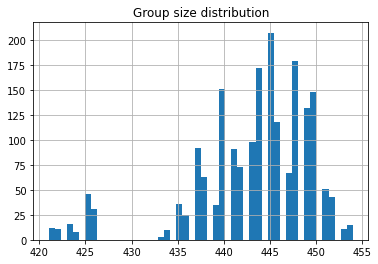

In [8]:
%%time
# prepare full dataset
feats, feat_names = load_signals()
n_day = horizons[h]
exret = load_exret(n_day)
data = preprocess_signals(feats, exret)

[Timestamp('2011-08-05 00:00:00'),
 Timestamp('2012-03-13 00:00:00'),
 Timestamp('2012-10-16 00:00:00'),
 Timestamp('2013-05-28 00:00:00'),
 Timestamp('2013-12-31 00:00:00')]

[I 2022-05-12 14:09:34,018] A new study created in memory with name: LGBM optimization
[I 2022-05-12 14:09:47,334] Trial 0 finished with value: -0.87675358583549 and parameters: {'selected_feats': 'feats_subset1', 'max_depth': 12, 'num_leaves': 19, 'learning_rate': 0.8451279929163642, 'objective': 'rank_xendcg', 'min_child_weight': 2.1767584269164186, 'min_child_samples': 25, 'subsample': 0.7350618519498153, 'subsample_freq': 6, 'reg_alpha': 0.00018718341893808252, 'reg_lambda': 1.020700036264509, 'n_estimators': 73}. Best is trial 0 with value: -0.87675358583549.
[I 2022-05-12 14:09:50,405] Trial 1 finished with value: -0.8797373167080591 and parameters: {'selected_feats': 'feats_subset1', 'max_depth': 9, 'num_leaves': 27, 'learning_rate': 1.2422686875863727, 'objective': 'rank_xendcg', 'min_child_weight': 2.8898273613958527, 'min_child_samples': 10, 'subsample': 0.9189836089517043, 'subsample_freq': 4, 'reg_alpha': 0.00046956724020952707, 'reg_lambda': 0.05364372376989927, 'n_estimat

[2022-05-13 00:09:45] {'selected_feats': 'feats_full', 'max_depth': 7, 'num_leaves': 60, 'learning_rate': 2.2927845836957332, 'objective': 'rank_xendcg', 'min_child_weight': 2.930102155179201, 'min_child_samples': 15, 'subsample': 0.6755053022966739, 'subsample_freq': 6, 'reg_alpha': 0.008044478600171353, 'reg_lambda': 0.08152456169952542, 'n_estimators': 281}
[2022-05-13 00:09:45] Highest NDCG is 0.8968834618408532


<Figure size 432x288 with 0 Axes>

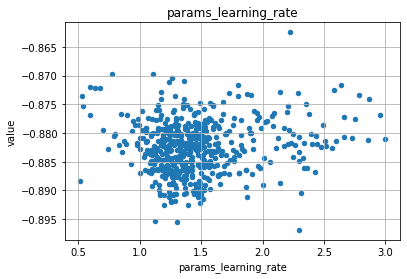

<Figure size 432x288 with 0 Axes>

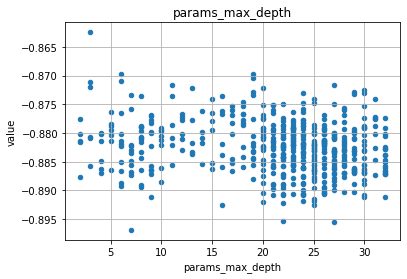

<Figure size 432x288 with 0 Axes>

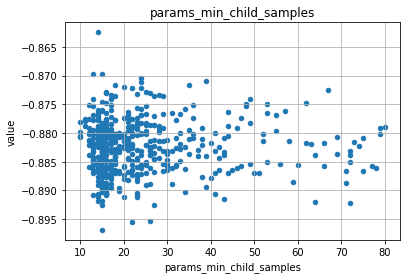

<Figure size 432x288 with 0 Axes>

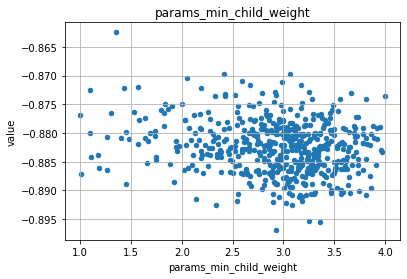

<Figure size 432x288 with 0 Axes>

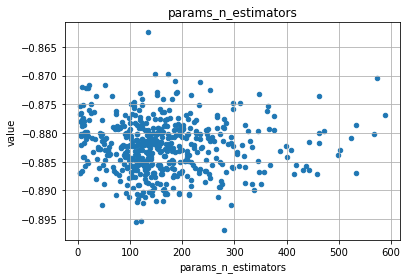

<Figure size 432x288 with 0 Axes>

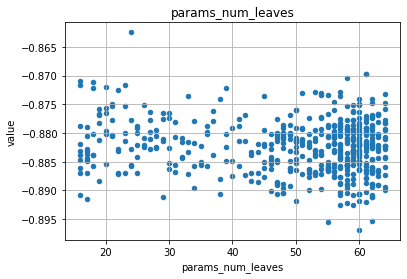

<Figure size 432x288 with 0 Axes>

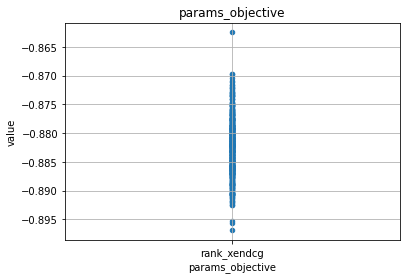

<Figure size 432x288 with 0 Axes>

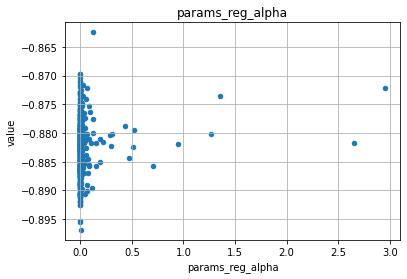

<Figure size 432x288 with 0 Axes>

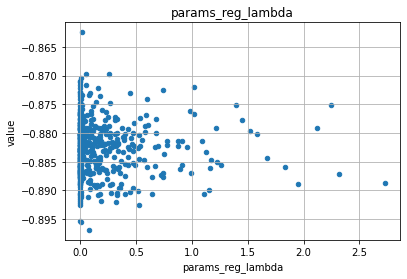

<Figure size 432x288 with 0 Axes>

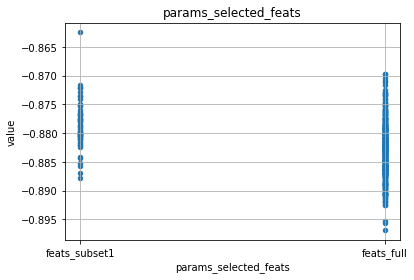

<Figure size 432x288 with 0 Axes>

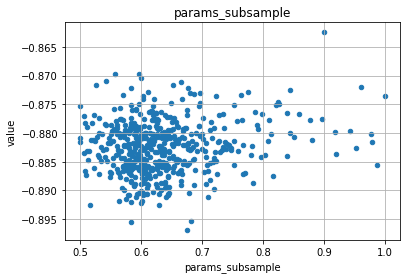

<Figure size 432x288 with 0 Axes>

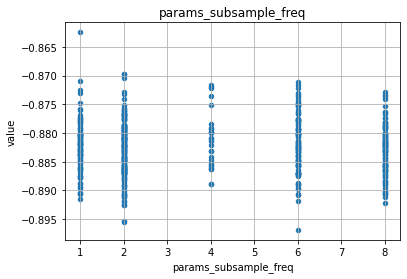

CPU times: user 3h 30min 14s, sys: 11min 11s, total: 3h 41min 26s
Wall time: 2h 14s


In [9]:
%%time
'''
Hyperparameter Optimization
'''
# get sampled dates for CV
s = pd.Series(data.date.unique()) \
    .loc[lambda x: x.between(x.min() + np.timedelta64(n_day_trn + n_day_horizon + n_day_val, 'D'), bt_start_date)] \
    .tolist()
sampled_dates = sorted(s[::len(s)//n_day_sample])
display(sampled_dates)

# run optimization
if run_hp_tune:
    best_params = optimize_hp()

In [10]:
%%time
'''
Fit model (with best params) for all dates
'''
# hard-code the best params if not running HP tuning here
if run_hp_tune==False:
    best_params = {'selected_feats': 'feats_subset1', 'sample_weight_p': 1.3887048885948596, 'max_depth': 10, 'num_leaves': 54, 'learning_rate': 0.1537015325324695, 'objective': 'lambdarank', 'min_child_weight': 3.3478798601563096, 'min_child_samples': 16, 'subsample': 0.5725379109999287, 'subsample_freq': 8, 'reg_alpha': 0.5445575343281451, 'reg_lambda': 0.21693106623962125}
# setup best params
lgbm_fixed_params = dict(
    boosting_type = 'gbdt',
    n_jobs = -1,
    random_state = 0,
    label_gain = [i for i in range(int(data['rank'].max()) + 1)],
    device_type = device_type
)
feats_suggest_dict = dict(
    feats_full = ['feat_ch_full_len_10k', 'feat_ch_item_1a_len_10k', 'feat_ch_item_1b_len_10k', 'feat_ch_item_3_len_10k', 'feat_full_cos_1gram_10k', 'feat_full_cos_2gram_10k', 'feat_full_jac_1gram_10k', 'feat_full_jac_2gram_10k', 'feat_item_1a_lev_10k', 'feat_item_7_lev_10k', 'feat_lm_postive_10k', 'feat_lm_uncertainty_10k', 'feat_lm_litigious_10k', 'feat_word2vec_10k', 'feat_sen_enc_10k', 'feat_item_sentiment_10k', 'feat_fls_sentiment_10k', 'feat_ch_full_len_10q', 'feat_full_cos_1gram_10q', 'feat_full_jac_1gram_10q', 'feat_word2vec_10q', 'feat_lm_postive_10q', 'feat_cnt_8k', 'feat_cnt_8k_diff'],
    feats_subset1 = ['feat_full_jac_1gram_10q','feat_full_cos_1gram_10q','feat_word2vec_10q','feat_lm_litigious_10k','feat_ch_full_len_10k','feat_item_7_lev_10k','feat_sen_enc_10k','feat_cnt_8k','feat_ch_full_len_10q']
)
params = (feats_suggest_dict[best_params['selected_feats']], 
          {x:best_params[x] for x in list(best_params) if x not in ['selected_feats']}, 
          lgbm_fixed_params)

# get full list of dates
date_list = pd.Series(data.date.unique()) \
        .loc[lambda x: x.between(x.min() + np.timedelta64(n_day_trn + n_day_horizon + n_day_val, 'D'), x.max())]
n_group = (date_list.max() - date_list.min()) / np.timedelta64(1,'D') / n_day_val
n_group = math.ceil(n_group + 1 + 1e-5)
date_list = pd.Series([date_list.min() + np.timedelta64(i * n_day_val,'D') for i in range(n_group)])
date_list = date_list[date_list.apply(lambda d: data.loc[lambda x: x.date.between(d + np.timedelta64(-n_day_val+1,'D'), d)].shape[0]) > 0]
date_list = date_list.tolist()
log(f'Total number of days to train model: {len(date_list)}')

# generate outputs for all dates
model_outputs = []
for date in date_list[:n_day_final_predict]:
    model_outputs.append(train_model(date, params, hp_tune=False))
    log(f'Completed model training for date {date}')

[2022-05-13 00:09:49] Total number of days to train model: 70
[2022-05-13 00:09:53] Completed model training for date 2011-08-05 00:00:00
[2022-05-13 00:09:57] Completed model training for date 2011-09-04 00:00:00
[2022-05-13 00:10:01] Completed model training for date 2011-10-04 00:00:00
[2022-05-13 00:10:06] Completed model training for date 2011-11-03 00:00:00
[2022-05-13 00:10:10] Completed model training for date 2011-12-03 00:00:00
[2022-05-13 00:10:14] Completed model training for date 2012-01-02 00:00:00
[2022-05-13 00:10:18] Completed model training for date 2012-02-01 00:00:00
[2022-05-13 00:10:23] Completed model training for date 2012-03-02 00:00:00
[2022-05-13 00:10:29] Completed model training for date 2012-04-01 00:00:00
[2022-05-13 00:10:34] Completed model training for date 2012-05-01 00:00:00
[2022-05-13 00:10:38] Completed model training for date 2012-05-31 00:00:00
[2022-05-13 00:10:43] Completed model training for date 2012-06-30 00:00:00
[2022-05-13 00:10:46] Comp

<Figure size 432x288 with 0 Axes>

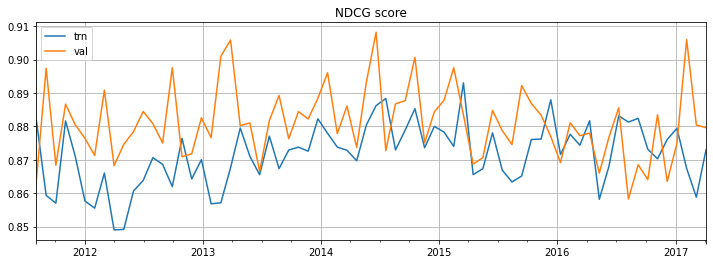

<Figure size 432x288 with 0 Axes>

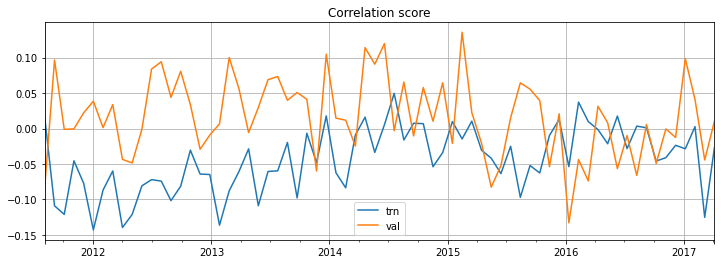

<Figure size 432x288 with 0 Axes>

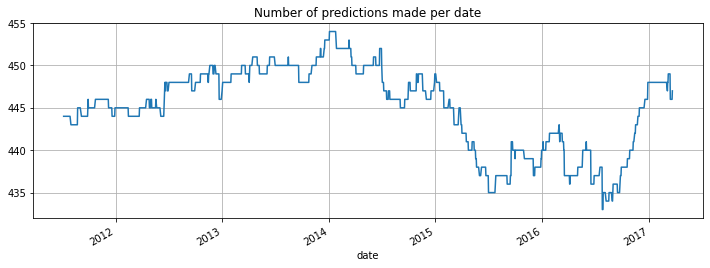

<Figure size 432x288 with 0 Axes>

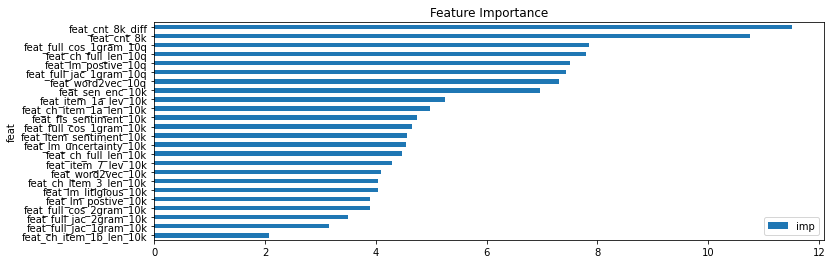

In [11]:
'''
Summary plots of model
'''
dates = pd.Series([x['date'] for x in model_outputs])

# ndcg score
ndcg_trn = pd.Series([x['ndcg_trn'] for x in model_outputs],index=dates)
ndcg_val = pd.Series([x['ndcg_val'] for x in model_outputs],index=dates)
new_plot()
plt.figure(figsize=(12, 4))
ndcg_trn.plot(label='trn')
ndcg_val.plot(label='val')
plt.grid()
plt.legend()
plt.title('NDCG score')
plt.show()

# correlation score
corr_trn = pd.Series([x['corr_trn'] for x in model_outputs],index=dates)
corr_val = pd.Series([x['corr_val'] for x in model_outputs],index=dates)
new_plot()
plt.figure(figsize=(12, 4))
corr_trn.plot(label='trn')
corr_val.plot(label='val')
plt.grid()
plt.legend()
plt.title('Correlation score')
plt.show()


# model predictions
pred_val_out = pd.concat([x['pred_val_out'] for x in model_outputs]).reset_index(drop=True)
new_plot()
plt.figure(figsize=(12, 4))
pred_val_out.groupby('date').size().plot()
plt.grid()
plt.title('Number of predictions made per date')
plt.show()

# feature importance
feat_imp = pd.concat([x['feat_imp'] for x in model_outputs]).groupby('feat').mean().sort_values('imp')
new_plot()
feat_imp.plot.barh(figsize=(12, 4))
plt.title('Feature Importance')
plt.show()

# export
save_pkl(model_outputs, 'model_outputs')
save_pkl(pred_val_out, 'pred_val_out')